In [1]:
pip install chart-studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing libraries

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir("../input"))


['stock-time-series-20050101-to-20171231', 'historical-hourly-weather-data']


**1. Introduction to Date and Time**

**1.1 Importing Time Series Data**



In [3]:
google = pd.read_csv("../input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=["Date"])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [4]:
humidity = pd.read_csv("../input/historical-hourly-weather-data/humidity.csv", index_col="datetime", parse_dates=["datetime"])
humidity.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,81.0,NaN,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,NaN,64.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,71.0,NaN,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,NaN,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,71.0,NaN,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,NaN,66.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,71.0,NaN,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,76.0,NaN,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN


**1.2 Cleaning and Preparing Time Series Data**

Google stocks data doesn't have any missing values but humidity data does. We can clean it using fillna() method

In [5]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method="ffill")
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


**1.3 Visualizing the Datasets**

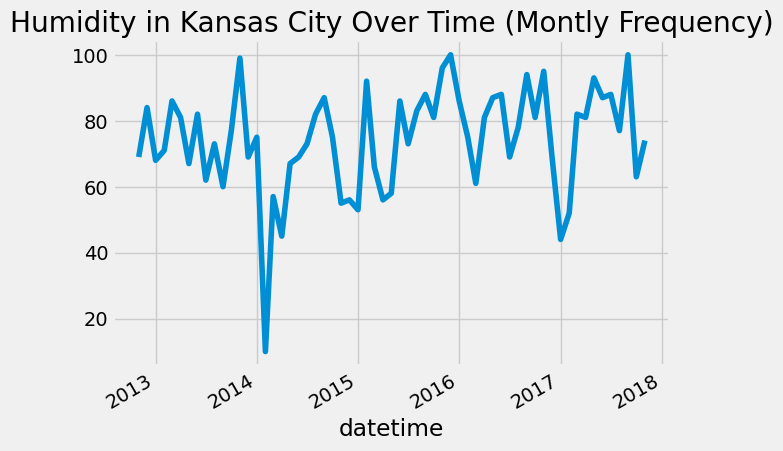

In [6]:
#asfreq() method is used to convert time series to a specified frequency, here it is montly frequency
humidity["Kansas City"].asfreq("M").plot()
plt.title("Humidity in Kansas City Over Time (Montly Frequency)")
plt.show()

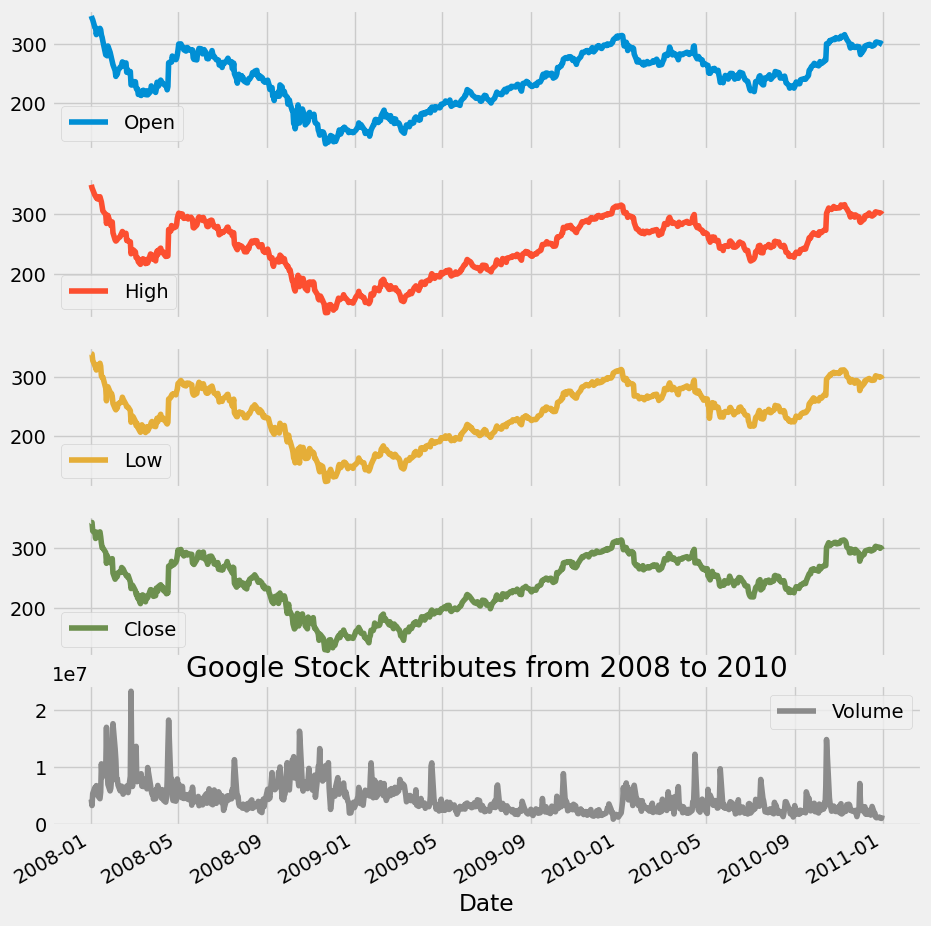

In [7]:
google["2008":"2010"].plot(subplots=True, figsize=(10,12))
plt.title("Google Stock Attributes from 2008 to 2010")
plt.savefig("stocks.png")
plt.show()

**1.4 Timestamps and Periods**

Timestamps are used to represent a point in time. Periods represent an interval in time.
They can also be converted to each other's form

In [8]:
#Creating a Timestamp
timestamp = pd.Timestamp(2017,1,1,12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [9]:
#Creating a Period
period = pd.Period("2017-01-01")
period

Period('2017-01-01', 'D')

In [10]:
#Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

True

In [11]:
#Converting timestamp to period
new_period = timestamp.to_period(freq="H")
new_period

Period('2017-01-01 12:00', 'h')

In [12]:
#Converting period to timestamp
new_timestamp = period.to_timestamp(freq="H", how="start")
new_timestamp

Timestamp('2017-01-01 00:00:00')

**1.5 Using date_range**

useful when you are creating your own time series attribute

In [13]:
#Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start="1/1/18", end="1/9/18")
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [14]:
#Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start="1/1/18", end="1/1/19", freq="M")
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [15]:
#Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end="1/4/2014", periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

**1.6 Using to_datetime**

pandas.to_datetime() is used for converting arguments to datetime

In [16]:
df = pd.DataFrame({"year": [2015,2016], "month": ["2","3"], "day": [4,5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [17]:
#DataFrame is converted to a datetime series
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [18]:
df = pd.to_datetime("01-01-2017")
df

Timestamp('2017-01-01 00:00:00')

**1.7 Shifting and Lags**

Shift moves the entire time series forward or backward

Lag refers to a shifted copy of a series, used for comparing current data with past data

By comparing the current value with previous values, you can identify upward or downward trends.
Shifting data helps measure how a time series correlates with its past values

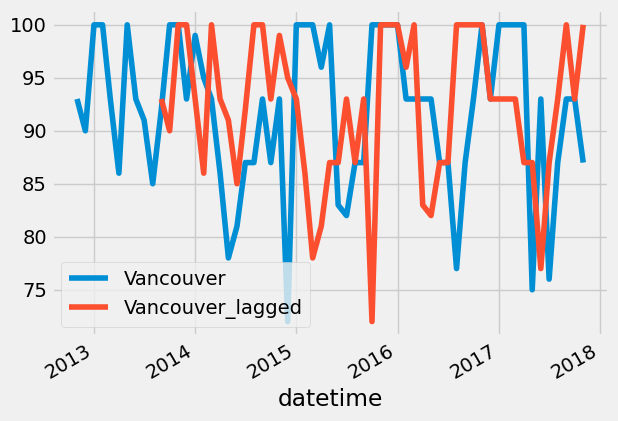

In [19]:
humidity["Vancouver"].asfreq("M").plot(legend=True)
shifted = humidity["Vancouver"].asfreq("M").shift(10).plot(legend=True)
shifted.legend(["Vancouver", "Vancouver_lagged"])
plt.show()

**1.8 Resampling**

Resampling is a technique in time series analysis where you change the frequency of your time series data. This involves aggregating data to a higher level (daily to monthly) or filling in the data to a lower level(monthly to daily)

Upsampling -> time series is resampled from low frequency to high frequency (monthly to daily frequency), it involves filling or interpolating missing data

Downsampling -> time series is resampled from high frequency to low frequency (weekly to monthly frequency), it involves aggregation of existing data, it helps to identify longer-term trends

In [20]:
pressure = pd.read_csv("../input/historical-hourly-weather-data/pressure.csv", index_col="datetime", parse_dates=["datetime"])
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,1031.0,NaN,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,NaN,1021.0,1017.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,1030.0,NaN,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,NaN,1023.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,1030.0,NaN,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,NaN,1024.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,1029.0,NaN,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,NaN,1026.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,1029.0,NaN,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,NaN,1027.0,1023.0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method="ffill")
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [22]:
pressure = pressure.fillna(method="bfill")
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


First we used ffill parameter which propagates the last valid observation to fill gaps, then we use bfill to propogate next valid observation to fill gaps

In [23]:
#Shape before resampling (downsampling)
pressure.shape

(45252, 36)

In [24]:
#We downsample from hourly to 3 day frequency aggregated using mean
pressure = pressure.resample("3D").mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [25]:
pressure.shape

(629, 36)

In [26]:
#We will upsample from 3 day frequency to daily frequency
pressure = pressure.resample('D').ffill()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [27]:
pressure.shape

(1885, 36)